In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from kaggle_submission import output_submission_csv
from models.neural_net import NeuralNetwork
from utils.data_process import get_CIFAR10_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading CIFAR-10
Now that you have implemented a neural network that passes gradient checks and works on toy data, you will test your network on the CIFAR-10 dataset.

In [2]:
# You can change these numbers for experimentation
# For submission be sure they are set to the default values
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 10000

data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [3]:
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_val -= mean_image
# X_test -= mean_image
print(y_train.shape)
print(X_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
# for x in y_train:
#     print(x)

(49000,)
(49000, 3072)
(1000, 3072)
(1000,)
(10000, 3072)
(10000,)


In [4]:
#set of functions needed to implement Adam
def set_zero(dictio):
    new_dictio={}
    for wx in dictio:
        new_dictio[wx]=np.zeros(dictio[wx].shape)
    return new_dictio
def dict_x_ele(dict1, ele):
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=np.multiply(dict1[wx],ele)
    return new_dictio
def dict_by_ele(dict1, ele): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=np.divide(dict1[wx],ele)
    return new_dictio    
def dict_sqr(dict1): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=np.square(dict1[wx])
    return new_dictio        
def dict_sqrt(dict1): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=np.sqrt(dict1[wx])
    return new_dictio   
def dict_add_ele(dict1,ele): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=dict1[wx]+ele
    return new_dictio     
def dict_by_dict(dict1,dict2): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=dict1[wx]/dict2[wx]
    return new_dictio 
def dict_minus_dict(dict1,dict2): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=dict1[wx]-dict2[wx]
    return new_dictio 
def dict_add_dict(dict1,dict2): 
    new_dictio={}
    for wx in dict1:
        new_dictio[wx]=dict1[wx]+dict2[wx]
    return new_dictio 

## Train using SGD
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

You can try different numbers of layers and other hyperparameters on the CIFAR-10 dataset below.

In [23]:
from random import shuffle

# Hyperparameters
input_size = 32 * 32 * 3
num_layers = 3
hidden_size = 80
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 40
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
regularization = 0.001

# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
val_accuracy = np.zeros(epochs)

# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)
    
    # Shuffle the dataset
    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]

    
    # Training
    # For each mini-batch...
    #################################
    #Implemented the linear decay in learning rate but found that results without it were more accurate
    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
    #################################
    for batch in range(TRAIN_IMAGES // batch_size):
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        # Create a mini-batch of training data and labels
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        # Run the backward pass of the model to update the weights and compute the loss
        loss,gradients=net.backward(X_batch,y_batch,"SGD",learning_rate,regularization)    
        train_loss[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    train_accuracy[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss[epoch]/=(TRAIN_IMAGES // batch_size)
    #net.params=dict_by_ele(net.params,(TRAIN_IMAGES // batch_size))
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy[epoch]= (np.sum(y_val==y_pred)/len(y_val))

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39


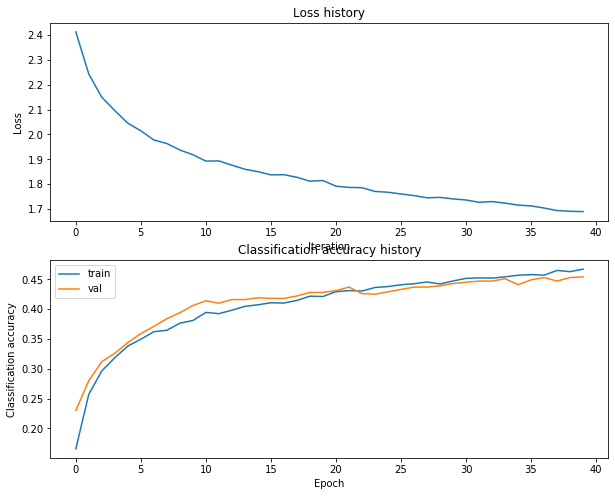

In [24]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## Train using Adam
Next we will train the same model using the Adam optimizer. You should take the above code for SGD and modify it to use Adam instead. For implementation details, see the lecture slides. The original paper that introduced Adam is also a good reference, and contains suggestions for default values: https://arxiv.org/pdf/1412.6980.pdf

In [30]:
   
# TODO: implement me
# Hyperparameters
################################################
# Implementing Adam for two and three layers
################################################



import copy
input_size = 32 * 32 * 3
num_layers = 3
hidden_size = 20
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 100
batch_size = 200
learning_rate = 1e-3 #0.025 #1e-3
learning_rate_decay = 0.95
regularization = 0.009
betas=(0.9, 0.999)
epsilon=1e-8
# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_adam = np.zeros(epochs)
train_accuracy_adam = np.zeros(epochs)
val_accuracy_adam = np.zeros(epochs)
    
w = copy.deepcopy(net.params)
m = set_zero(w) #creates a new dictionary which has the same size/elemets as the one passesed all set to zero
v = set_zero(w)
w_prev=set_zero(w)
v_prev=set_zero(w)
m_prev=set_zero(w)
# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)

    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]
    for batch in range(TRAIN_IMAGES // batch_size):
        # Create a mini-batch of training data and labels
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy_adam[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        
        # Run the backward pass of the model to update the weights and compute the loss
        loss, gradients=net.backward(X_batch,y_batch,learning_rate,regularization)
        
        m=dict_add_dict(dict_x_ele(m_prev,betas[0]),dict_x_ele(gradients,(1-betas[0])))
        
        v=dict_add_dict(dict_x_ele(v_prev,betas[1]),dict_x_ele(dict_sqr(gradients),(1-betas[1])))
                
        m_new=dict_by_ele(m,(1-betas[0]))
        v_new=dict_by_ele(v,(1-betas[1]))
        
        w=dict_minus_dict(w_prev,dict_by_dict(dict_x_ele(m_new,learning_rate),(dict_add_ele(dict_sqrt(v_new),epsilon))))
        net.params=copy.copy(w)
        #w=w_prev-(alpha*m_new/(np.sqrt(v_new)+epsilon))
        
        w_prev=copy.copy(w)
        v_prev=copy.copy(v)
        m_prev=copy.copy(m)

        train_loss_adam[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    train_accuracy_adam[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss_adam[epoch]/=(TRAIN_IMAGES // batch_size)
    #net.params=dict_by_ele(net.params,(TRAIN_IMAGES // batch_size))
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy_adam[epoch]= (np.sum(y_val==y_pred)/len(y_val))

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99


## Graph loss and train/val accuracies

Examining the loss graph along with the train and val accuracy graphs should help you gain some intuition for the hyperparameters you should try in the hyperparameter tuning below. It should also help with debugging any issues you might have with your network.

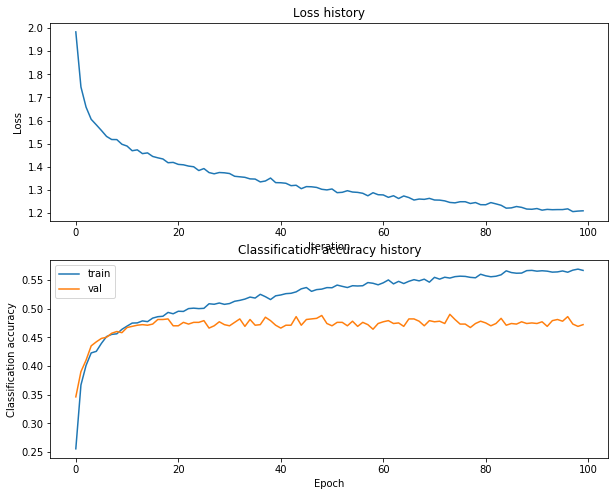

In [32]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss_adam)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_adam, label='train')
plt.plot(val_accuracy_adam, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [ ]:
#Tuning SGD 2 layers


##################################
# Tuninig in the various hyper parameters for the SGD update
##################################
from random import shuffle

# Hyperparameters

# hidden_size = 20
# epochs = 10
# batch_size = 200
# learning_rate = 1e-3
# regularization = 0.1

###########################################
epochs_list=[100,150]
batch_size_list=[50,200,400,1000]
hidden_size_list=[20,40,80,120]
learning_rate_list =[1e-1,1e-2,1e-3]
regularization_list =[0.95,0.4,0.05,0.005]
###########################################


input_size = 32 * 32 * 3
num_layers = 2
num_classes = 10
learning_rate_decay = 0.95

# Initialize a new neural network model


# Variables to store performance for each epoch


# For each epoch...
print("Dataset   batch_size    hidden_sizes  regulariztion   epochs    accuracy  ")
for batch_size in batch_size_list:
    for hidden_size in hidden_size_list:
        hidden_sizes = [hidden_size] * (num_layers - 1)
        for learning_rate in learning_rate_list:
            for regularization in regularization_list:
                ff=0
                for epoch in range(epochs_list[ff]):
                    net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)
                    test_accuracy=0
                    train_loss = 0
                    train_accuracy = 0
                    val_accuracy = 0
                    #################################
                    #Implemented the linear decay in learning rate but found that results without it were more accurate
                    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
                    #################################
                    # Shuffle the dataset
                    ind_list = [i for i in range(X_train.shape[0])]
                    shuffle(ind_list)
                    X_train  = X_train[ind_list,:]
                    y_train = y_train[ind_list]
                    # Training
                    # For each mini-batch...
                    for batch in range(TRAIN_IMAGES // batch_size):
                        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
                        # Create a mini-batch of training data and labels
                        X_batch = X_train[batch_indices]
                        y_batch = y_train[batch_indices]
                        # Run the forward pass of the model to get a prediction and compute the accuracy
                        scores=net.forward(X_batch)
                        y_pred=np.argmax(scores, axis=1)
                        train_accuracy+= (np.sum(y_batch==y_pred)/len(y_batch))
                        # Run the backward pass of the model to update the weights and compute the loss
                        loss,gradients=net.backward(X_batch,y_batch,"SGD",learning_rate,regularization)    
                        train_loss+=loss

                    # Validation
                    # No need to run the backward pass here, just run the forward pass to compute accuracy
                    train_accuracy/=(TRAIN_IMAGES // batch_size)
                    train_loss/=(TRAIN_IMAGES // batch_size)
                    #net.params=dict_by_ele(net.params,(TRAIN_IMAGES // batch_size))
                    scores=net.forward(X_val)
                    y_pred=np.argmax(scores, axis=1)
                    val_accuracy= (np.sum(y_val==y_pred)/len(y_val))
                    scores=net.forward(X_test)
                    y_pred=np.argmax(scores, axis=1)
                    test_accuracy= (np.sum(y_test==y_pred)/len(y_test))
                    print("Trainng    %f    %f     %f       %f    %f" % (batch_size, hidden_size, regularization, epoch, train_accuracy))
                    print("Validation  %f    %f    %f      %f       %f" % (batch_size, hidden_size, regularization, epoch, val_accuracy))
                    print("Test       %f    %f    %f       %f       %f" % (batch_size, hidden_size, regularization, epoch, test_accuracy))
                ff+=1


In [51]:
#Tuning SGD

##########################################
# Best two layer SGD NN
##########################################


from random import shuffle

# Hyperparameters
input_size = 32 * 32 * 3
num_layers = 2
hidden_size = 80#80#20
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 150 #200
batch_size = 200
learning_rate = 1e-3#0.0001#1e-3 the best #0.5 NoWrk #0.05 NoWrk
learning_rate_decay = 0.95
regularization = 0.009 #0.1 #0.009 worked really well with 1e-3 and 80 hidden sizes

# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
val_accuracy = np.zeros(epochs)
test_accuracy = np.zeros(epochs)
# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)
    
    # Shuffle the dataset
    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]

    
    # Training
    # For each mini-batch...
    #################################
    #Implemented the linear decay in learning rate but found that results without it were more accurate
    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
    #################################
    for batch in range(TRAIN_IMAGES // batch_size):
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        # Create a mini-batch of training data and labels
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        # Run the backward pass of the model to update the weights and compute the loss
        loss,gradients=net.backward(X_batch,y_batch,"SGD",learning_rate,regularization)    
        train_loss[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    
    train_accuracy[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss[epoch]/=(TRAIN_IMAGES // batch_size)
    
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    
    scores=net.forward(X_test)
    y_pred=np.argmax(scores, axis=1)
    test_accuracy[epoch]= (np.sum(y_test==y_pred)/len(y_test))
    print(train_accuracy[epoch],val_accuracy[epoch],test_accuracy[epoch])

epoch: 0
0.2041020408163263 0.251 0.2647
epoch: 1
0.2922857142857144 0.306 0.3137
epoch: 2
0.324061224489796 0.336 0.344
epoch: 3
0.3506122448979591 0.361 0.3594
epoch: 4
0.3654285714285716 0.372 0.3723
epoch: 5
0.37651020408163277 0.386 0.3801
epoch: 6
0.38544897959183666 0.391 0.3878
epoch: 7
0.39863265306122464 0.4 0.3933
epoch: 8
0.40479591836734724 0.409 0.3981
epoch: 9
0.41183673469387755 0.406 0.4021
epoch: 10
0.41457142857142865 0.417 0.4078
epoch: 11
0.41761224489795923 0.418 0.4142
epoch: 12
0.42463265306122466 0.42 0.4181
epoch: 13
0.4261224489795919 0.42 0.4195
epoch: 14
0.42422448979591865 0.426 0.4215
epoch: 15
0.430061224489796 0.43 0.4246
epoch: 16
0.43473469387755104 0.432 0.4284
epoch: 17
0.43936734693877555 0.43 0.4321
epoch: 18
0.43771428571428556 0.429 0.434
epoch: 19
0.4422857142857143 0.435 0.4362
epoch: 20
0.4471632653061229 0.432 0.4376
epoch: 21
0.4463265306122449 0.431 0.4397
epoch: 22
0.4506734693877552 0.425 0.442
epoch: 23
0.44991836734693885 0.435 0.4407


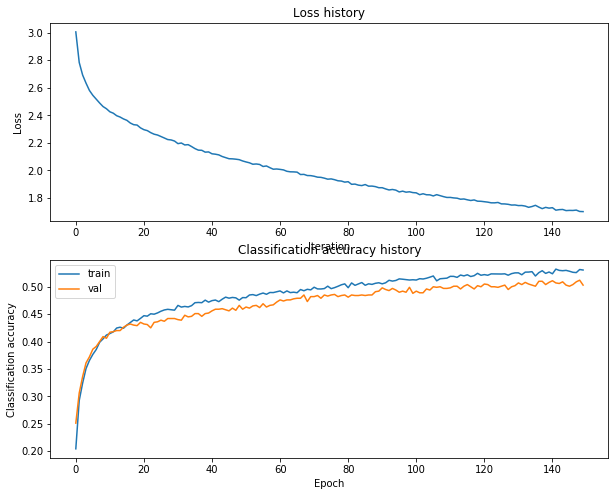

0.5322244897959185
0.5001


In [52]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()
print(max(train_accuracy))
print(max(test_accuracy))
#print(train_accuracy)

In [53]:
scores=net.forward(X_test)
y_pred=np.argmax(scores, axis=1)
test_accuracy= (np.sum(y_test==y_pred)/len(y_test))
print(test_accuracy)
best_2layer_sgd_prediction=y_pred
output_submission_csv('kaggle/nn_2layer_sgd_submission.csv', best_2layer_sgd_prediction)

0.5001


In [54]:
##########################################
# Best three layer SGD NN
##########################################
#Tuning SGD 3 layers
from random import shuffle

# Hyperparameters
input_size = 32 * 32 * 3
num_layers = 3
hidden_size = 120#80#20
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 200 #200
batch_size = 200
learning_rate = 1e-3#0.0001#1e-3 the best #0.5 NoWrk #0.05 NoWrk
learning_rate_decay = 0.95
regularization = 0.0009 #0.1 #0.009 worked really well with 1e-3 and 80 hidden sizes

# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_three = np.zeros(epochs)
train_accuracy_three = np.zeros(epochs)
val_accuracy_three = np.zeros(epochs)
test_accuracy_three = np.zeros(epochs)
# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)
    
    # Shuffle the dataset
    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]

    
    # Training
    # For each mini-batch...
    #################################
    #Implemented the linear decay in learning rate but found that results without it were more accurate
    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
    #################################
    for batch in range(TRAIN_IMAGES // batch_size):
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        # Create a mini-batch of training data and labels
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy_three[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        # Run the backward pass of the model to update the weights and compute the loss
        loss,gradients=net.backward(X_batch,y_batch,"SGD",learning_rate,regularization)    
        train_loss_three[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    
    train_accuracy_three[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss_three[epoch]/=(TRAIN_IMAGES // batch_size)
    
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy_three[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    
    scores=net.forward(X_test)
    y_pred=np.argmax(scores, axis=1)
    test_accuracy_three[epoch]= (np.sum(y_test==y_pred)/len(y_test))
    print(train_accuracy_three[epoch],val_accuracy_three[epoch],test_accuracy_three[epoch])


epoch: 0
0.19463265306122451 0.26 0.2444
epoch: 1
0.2728163265306122 0.317 0.2925
epoch: 2
0.3068571428571429 0.335 0.3243
epoch: 3
0.331938775510204 0.356 0.3442
epoch: 4
0.348918367346939 0.367 0.3548
epoch: 5
0.3596326530612247 0.384 0.361
epoch: 6
0.3712244897959183 0.389 0.3711
epoch: 7
0.3759387755102042 0.393 0.3775
epoch: 8
0.3809795918367347 0.393 0.3825
epoch: 9
0.39179591836734695 0.401 0.3885
epoch: 10
0.3929795918367347 0.4 0.3929
epoch: 11
0.3952653061224488 0.408 0.3987
epoch: 12
0.40508163265306135 0.412 0.403
epoch: 13
0.4095510204081631 0.415 0.4064
epoch: 14
0.4113265306122451 0.423 0.4083
epoch: 15
0.41936734693877575 0.419 0.413
epoch: 16
0.4257142857142858 0.419 0.4153
epoch: 17
0.42418367346938757 0.421 0.4158
epoch: 18
0.4258367346938774 0.419 0.4177
epoch: 19
0.4247551020408159 0.421 0.4225
epoch: 20
0.4336734693877548 0.433 0.4234
epoch: 21
0.4336122448979591 0.432 0.4265
epoch: 22
0.43891836734693895 0.427 0.4295
epoch: 23
0.44159183673469365 0.439 0.4296
epo

0.6071020408163263 0.519 0.5153
epoch: 196
0.6111428571428565 0.524 0.5138
epoch: 197
0.6101836734693877 0.527 0.5152
epoch: 198
0.6054897959183677 0.526 0.5161
epoch: 199
0.6072448979591835 0.527 0.517


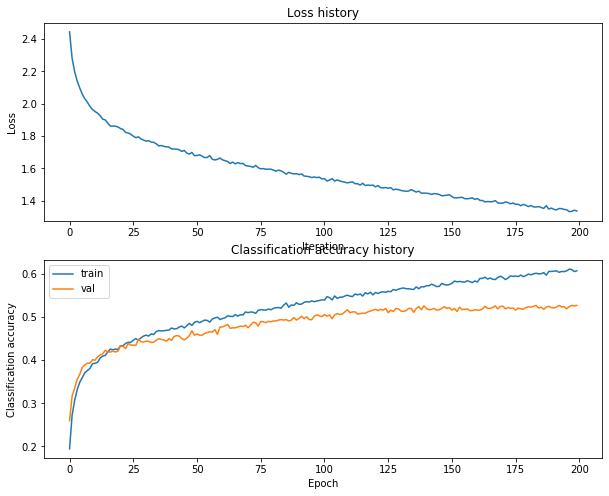

0.6111428571428565
0.517


In [57]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss_three)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_three, label='train')
plt.plot(val_accuracy_three, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()
print(max(train_accuracy_three))
print(max(test_accuracy_three))
#print(train_accuracy)

In [58]:
scores=net.forward(X_test)
y_pred=np.argmax(scores, axis=1)
test_accuracy= (np.sum(y_test==y_pred)/len(y_test))
print(test_accuracy)
best_3layer_sgd_prediction=y_pred
output_submission_csv('kaggle/nn_3layer_sgd_submission.csv', best_3layer_sgd_prediction)

0.517


In [73]:
#Tuning Adam 2 layers
# TODO: implement me
# Hyperparameters

##########################################
# Best two  layer Adam NN
##########################################
import copy
from random import shuffle
input_size = 32 * 32 * 3
num_layers = 2
hidden_size = 100#20
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 50
batch_size = 200
learning_rate = 1e-3#1e-3 #0.025 #1e-3
learning_rate_decay = 0.95
regularization = 0.00009 #0.025
betas=(0.9, 0.999)
epsilon=1e-8
# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_adam_two = np.zeros(epochs)
train_accuracy_adam_two = np.zeros(epochs)
val_accuracy_adam_two = np.zeros(epochs)
test_accuracy_adam_two = np.zeros(epochs)   

w = copy.deepcopy(net.params)
m = set_zero(w) #creates a new dictionary which has the same size/elemets as the one passesed all set to zero
v = set_zero(w)
w_prev=set_zero(w)
v_prev=set_zero(w)
m_prev=set_zero(w)
# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)

    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]
    #################################
    #Implemented the linear decay in learning rate but found that results without it were more accurate
    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
    #################################
    for batch in range(TRAIN_IMAGES // batch_size):
        # Create a mini-batch of training data and labels
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy_adam_two[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        
        # Run the backward pass of the model to update the weights and compute the loss
        loss, gradients=net.backward(X_batch,y_batch,learning_rate,regularization)
        #gradients=dict_by_ele(gradients,batch_size)
        m=dict_add_dict(dict_x_ele(m_prev,betas[0]),dict_x_ele(gradients,(1-betas[0])))
        
        v=dict_add_dict(dict_x_ele(v_prev,betas[1]),dict_x_ele(dict_sqr(gradients),(1-betas[1])))
                
        m_new=dict_by_ele(m,(1-betas[0]))
        v_new=dict_by_ele(v,(1-betas[1]))
        
        w=dict_minus_dict(w_prev,dict_by_dict(dict_x_ele(m_new,learning_rate),(dict_add_ele(dict_sqrt(v_new),epsilon))))
        net.params=copy.copy(w)
        #w=w_prev-(alpha*m_new/(np.sqrt(v_new)+epsilon))
        
        w_prev=copy.copy(w)
        v_prev=copy.copy(v)
        m_prev=copy.copy(m)

        train_loss_adam_two[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    train_accuracy_adam_two[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss_adam_two[epoch]/=(TRAIN_IMAGES // batch_size)
    #net.params=dict_by_ele(net.params,(TRAIN_IMAGES // batch_size))
#     scores=net.forward(X_val)
#     y_pred=np.argmax(scores, axis=1)
#     val_accuracy_adam[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy_adam_two[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    
    scores=net.forward(X_test)
    y_pred=np.argmax(scores, axis=1)
    test_accuracy_adam_two[epoch]= (np.sum(y_test==y_pred)/len(y_test))
    print(train_accuracy_adam_two[epoch],val_accuracy_adam_two[epoch],test_accuracy_adam_two[epoch])

epoch: 0
0.41197959183673466 0.48 0.4625
epoch: 1
0.49 0.506 0.4845
epoch: 2
0.516122448979592 0.493 0.4862
epoch: 3
0.533387755102041 0.509 0.4985
epoch: 4
0.5498979591836731 0.504 0.4963
epoch: 5
0.5637755102040818 0.509 0.5041
epoch: 6
0.5829387755102042 0.512 0.5086
epoch: 7
0.5827959183673471 0.527 0.5117
epoch: 8
0.5976938775510203 0.521 0.5171
epoch: 9
0.6036122448979593 0.521 0.5142
epoch: 10
0.6110408163265307 0.517 0.5097
epoch: 11
0.617163265306123 0.515 0.5132
epoch: 12
0.6250612244897958 0.534 0.5122
epoch: 13
0.6329795918367349 0.528 0.5131
epoch: 14
0.6352857142857143 0.535 0.5147
epoch: 15
0.6426326530612243 0.527 0.5115
epoch: 16
0.6469999999999998 0.525 0.5116
epoch: 17
0.654408163265306 0.524 0.5152
epoch: 18
0.6526122448979594 0.538 0.5063
epoch: 19
0.6645714285714291 0.537 0.5124
epoch: 20
0.665979591836735 0.536 0.514
epoch: 21
0.6720816326530613 0.53 0.5144
epoch: 22
0.6744081632653057 0.532 0.5143
epoch: 23
0.679387755102041 0.542 0.5208
epoch: 24
0.686571428571

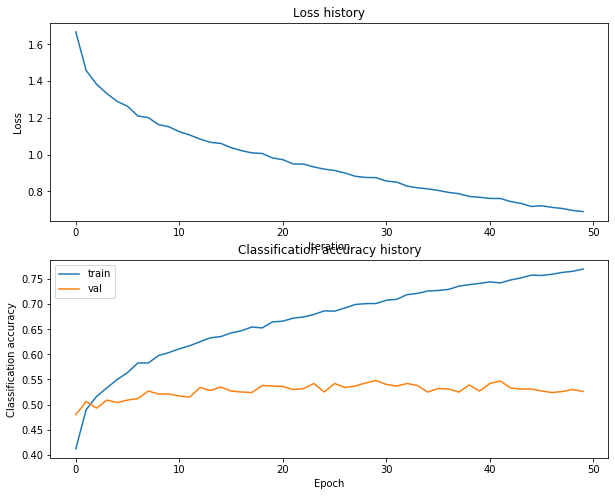

0.7696326530612247
0.5208


In [74]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss_adam_two)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_adam_two, label='train')
plt.plot(val_accuracy_adam_two, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()
print(max(train_accuracy_adam_two))
print(max(test_accuracy_adam_two))

In [78]:
#############################################################################
# For the Adam gradient updated 2-layer NN we observe that even for a very low
# value of regularization as the training error decreases with the increasing 
# number of epochs the training accuracy keeps on increasing however, the 
# validation and testing accuracy increase upto a certain number of epochs 
# and then start decreasing. This might be due to the fact that Adam gradient method
# causes faster convergence of results as compared to SDG and for lesser number of 
# epochs we get the best Adam results given the parameters. However, if we don't stop
# the training the model overlearns or overfits the data which increases training 
# accuracy but decreases the validation and testing accuracy. So we do only 50 epochs
# for Adam gradient methods as compared to 100-150 for SGD.
#############################################################################
scores=net.forward(X_test)
y_pred=np.argmax(scores, axis=1)
test_accuracy= (np.sum(y_test==y_pred)/len(y_test))
print(test_accuracy)
best_2layer_adam_prediction=y_pred
output_submission_csv('kaggle/nn_2layer_sgd_submission.csv', best_2layer_adam_prediction)

0.5009


In [67]:
#Tuning Adam 3 layers
# TODO: implement me
# Hyperparameters

##########################################
# Best three layer Adam NN
##########################################
import copy
from random import shuffle
input_size = 32 * 32 * 3
num_layers = 3
hidden_size = 100 #80 causes large distances between val and train
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 40
batch_size = 200
learning_rate = 1e-3 #0.025 #1e-3
learning_rate_decay = 0.95
regularization = 0.00009
betas=(0.9, 0.999)
epsilon=1e-8
# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_adam_three = np.zeros(epochs)
train_accuracy_adam_three = np.zeros(epochs)
val_accuracy_adam_three = np.zeros(epochs)
test_accuracy_adam_three = np.zeros(epochs)       
w = copy.deepcopy(net.params)
m = set_zero(w) #creates a new dictionary which has the same size/elemets as the one passesed all set to zero
v = set_zero(w)
w_prev=set_zero(w)
v_prev=set_zero(w)
m_prev=set_zero(w)
# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)

    ind_list = [i for i in range(X_train.shape[0])]
    shuffle(ind_list)
    X_train  = X_train[ind_list,:]
    y_train = y_train[ind_list]
    #################################
    #Implemented the linear decay in learning rate but found that results without it were more accurate
    #learning_rate=learning_rate/(1+learning_rate_decay*epoch)
    #################################
    
        
    for batch in range(TRAIN_IMAGES // batch_size):
        # Create a mini-batch of training data and labels
        batch_indices = np.random.choice(range(X_train.shape[0]), size=batch_size)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        scores=net.forward(X_batch)
        y_pred=np.argmax(scores, axis=1)
        train_accuracy_adam_three[epoch] += (np.sum(y_batch==y_pred)/len(y_batch))
        
        # Run the backward pass of the model to update the weights and compute the loss
        loss, gradients=net.backward(X_batch,y_batch,learning_rate,regularization)
        
        m=dict_add_dict(dict_x_ele(m_prev,betas[0]),dict_x_ele(gradients,(1-betas[0])))
        
        v=dict_add_dict(dict_x_ele(v_prev,betas[1]),dict_x_ele(dict_sqr(gradients),(1-betas[1])))
                
        m_new=dict_by_ele(m,(1-betas[0]))
        v_new=dict_by_ele(v,(1-betas[1]))
        
        w=dict_minus_dict(w_prev,dict_by_dict(dict_x_ele(m_new,learning_rate),(dict_add_ele(dict_sqrt(v_new),epsilon))))
        net.params=copy.copy(w)
        #w=w_prev-(alpha*m_new/(np.sqrt(v_new)+epsilon))
        
        w_prev=copy.copy(w)
        v_prev=copy.copy(v)
        m_prev=copy.copy(m)

        train_loss_adam_three[epoch]+=loss

    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    train_accuracy_adam_three[epoch]/=(TRAIN_IMAGES // batch_size)
    train_loss_adam_three[epoch]/=(TRAIN_IMAGES // batch_size)
    #net.params=dict_by_ele(net.params,(TRAIN_IMAGES // batch_size))
#     scores=net.forward(X_val)
#     y_pred=np.argmax(scores, axis=1)
#     val_accuracy_adam[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    
    scores=net.forward(X_val)
    y_pred=np.argmax(scores, axis=1)
    val_accuracy_adam_three[epoch]= (np.sum(y_val==y_pred)/len(y_val))
    
    scores=net.forward(X_test)
    y_pred=np.argmax(scores, axis=1)
    test_accuracy_adam_three[epoch]= (np.sum(y_test==y_pred)/len(y_test))
    print(train_accuracy_adam_three[epoch],val_accuracy_adam_three[epoch],test_accuracy_adam_three[epoch])

epoch: 0
0.3337142857142858 0.447 0.4181
epoch: 1
0.4507959183673469 0.453 0.4554
epoch: 2
0.48481632653061274 0.476 0.4781
epoch: 3
0.5112857142857143 0.509 0.4936
epoch: 4
0.5336734693877553 0.514 0.5024
epoch: 5
0.5390816326530612 0.524 0.5118
epoch: 6
0.5562040816326532 0.51 0.5072
epoch: 7
0.5686326530612242 0.524 0.5177
epoch: 8
0.5770000000000001 0.527 0.5188
epoch: 9
0.5889591836734694 0.532 0.5188
epoch: 10
0.5929591836734699 0.542 0.5256
epoch: 11
0.6007755102040816 0.537 0.5231
epoch: 12
0.6111428571428573 0.535 0.5251
epoch: 13
0.6195306122448979 0.535 0.5267
epoch: 14
0.6250816326530613 0.55 0.5285
epoch: 15
0.6325918367346943 0.548 0.5219
epoch: 16
0.6380816326530614 0.548 0.5252
epoch: 17
0.6433877551020408 0.543 0.5272
epoch: 18
0.6488571428571427 0.547 0.5237
epoch: 19
0.653918367346939 0.543 0.5281
epoch: 20
0.6598163265306124 0.541 0.5253
epoch: 21
0.6629591836734697 0.536 0.53
epoch: 22
0.6700612244897967 0.548 0.5246
epoch: 23
0.6785918367346936 0.533 0.5217
epoch:

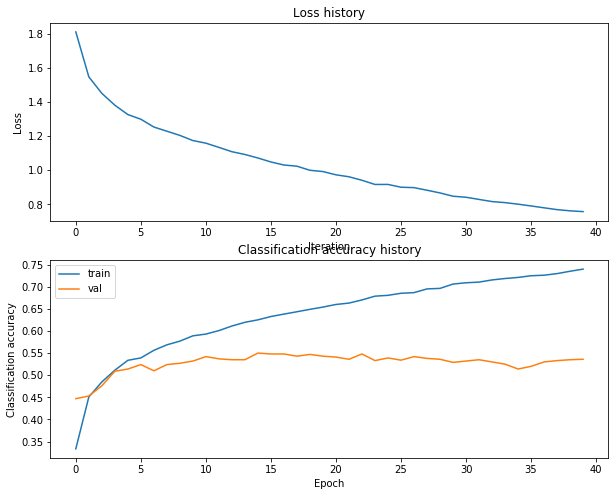

0.739714285714286
0.53


In [68]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss_adam_three)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_adam_three, label='train')
plt.plot(val_accuracy_adam_three, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()
print(max(train_accuracy_adam_three))
print(max(test_accuracy_adam_three))

In [70]:
#############################################################################
# For the Adam gradient updated 3-layer NN we observe that even for a very low
# value of regularization as the training error decreases with the increasing 
# number of epochs the training accuracy keeps on increasing however, the 
# validation and testing accuracy increase upto a certain number of epochs 
# and then start decreasing. This might be due to the fact that Adam gradient method
# causes faster convergence of results as compared to SDG and for lesser number of 
# epochs we get the best Adam results given the parameters. However, if we don't stop
# the training the model overlearns or overfits the data which increases training 
# accuracy but decreases the validation and testing accuracy. So we do only 40 epochs
# for Adam gradient methods as compared to 100-150 for SGD.
#############################################################################
scores=net.forward(X_test)
y_pred=np.argmax(scores, axis=1)
test_accuracy= (np.sum(y_test==y_pred)/len(y_test))
print(test_accuracy)
best_3layer_adam_prediction=y_pred
output_submission_csv('kaggle/best_3layer_adam_prediction.csv', best_3layer_adam_prediction)

0.5158


## Hyperparameter tuning

Once you have successfully trained a network you can tune your hyparameters to increase your accuracy.

Based on the graphs of the loss function above you should be able to develop some intuition about what hyperparameter adjustments may be necessary. A very noisy loss implies that the learning rate might be too high, while a linearly decreasing loss would suggest that the learning rate may be too low. A large gap between training and validation accuracy would suggest overfitting due to large model without much regularization. No gap between training and validation accuracy would indicate low model capacity. 

You will compare networks of two and three layers using the different optimization methods you implemented. 

The different hyperparameters you can experiment with are:
- **Batch size**: We recommend you leave this at 200 initially which is the batch size we used. 
- **Number of iterations**: You can gain an intuition for how many iterations to run by checking when the validation accuracy plateaus in your train/val accuracy graph.
- **Initialization** Weight initialization is very important for neural networks. We used the initialization `W = np.random.randn(n) / sqrt(n)` where `n` is the input dimension for layer corresponding to `W`. We recommend you stick with the given initializations, but you may explore modifying these. Typical initialization practices: http://cs231n.github.io/neural-networks-2/#init
- **Learning rate**: Generally from around 1e-4 to 1e-1 is a good range to explore according to our implementation.
- **Learning rate decay**: We recommend a 0.95 decay to start.
- **Hidden layer size**: You should explore up to around 120 units per layer. For three-layer network, we fixed the two hidden layers to be the same size when obtaining the target numbers. However, you may experiment with having different size hidden layers.
- **Regularization coefficient**: We recommend trying values in the range 0 to 0.1. 

Hints:
- After getting a sense of the parameters by trying a few values yourself, you will likely want to write a few for-loops to traverse over a set of hyperparameters.
- If you find that your train loss is decreasing, but your train and val accuracy start to decrease rather than increase, your model likely started minimizing the regularization term. To prevent this you will need to decrease the regularization coefficient. 

## Run on the test set
When you are done experimenting, you should evaluate your final trained networks on the test set.

In [ ]:
#############################################################################
# I have split this section into 4 different cells with their respective NN codes 
# and shown above
#############################################################################

best_2layer_sgd_prediction = None
best_3layer_sgd_prediction = None
best_2layer_adam_prediction = None
best_3layer_adam_prediction = None

## Kaggle output

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle. Use the following code to do so:

In [ ]:
#############################################################################
# I have split this section into 4 different cells with their respective NN codes 
# and shown above
#############################################################################

output_submission_csv('nn_2layer_sgd_submission.csv', best_2layer_sgd_prediction)
output_submission_csv('nn_3layer_sgd_submission.csv', best_3layer_sgd_prediction)
output_submission_csv('nn_2layer_adam_submission.csv', best_2layer_adam_prediction)
output_submission_csv('nn_3layer_adam_submission.csv', best_3layer_adam_prediction)

## Compare SGD and Adam
Create graphs to compare training loss and validation accuracy between SGD and Adam. The code is similar to the above code, but instead of comparing train and validation, we are comparing SGD and Adam.

In [ ]:
# TODO: implement me
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.plot(train_loss_adam_three)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2, 1, 2)
plt.plot(train_accuracy_adam_three, label='train')
plt.plot(val_accuracy_adam_three, label='val')
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()